### Madrid Airbnb Dataset ###

For our project we chose the Madrid Airbnb dataset. It consists of 6 files that contain data about airbnb places in the city:
* calendar.csv - this file includes the availability of places depending on the dates of arrival, as well as the prices and number of min and max nights that are possible to book.
* reviews.csv - the dataset contains the dates of the collected reviews
* reviews_detailed.csv - this table extends the previous file on the author of the review and the review content
* neighbourhoods.csv - the file groups the particular neighbourhods
* listings.csv - this document contains information such as name, hostname, neighbourhood, location, type of room/flat, price, min nights, availability and reviews about a particular place
* listings_detailed.csv - this file extends the previous one by adding the links to the website of such place and its description. On top of that we can obtain some statistical data describing number of reviews or room scores.

Predictive Pricing Platform
Neighborhood Investment Advisory Tool
Tourist Accommodation Recommender
Short-Term Rental Market Dashboard
Host Performance Optimization System

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rusiano/madrid-airbnb-data")

print("Path to dataset files:", path)

100%|██████████| 102M/102M [00:05<00:00, 19.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/rusiano/madrid-airbnb-data/versions/2


In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import warnings

In [3]:
dataset_files = os.listdir(path)
print("Files in dataset:", dataset_files)

Files in dataset: ['reviews_detailed.csv', 'calendar.csv', 'neighbourhoods.csv', 'listings.csv', 'reviews.csv', 'neighbourhoods.geojson', 'listings_detailed.csv']


In [4]:
print([file for file in dataset_files if file.endswith('.csv')])

['reviews_detailed.csv', 'calendar.csv', 'neighbourhoods.csv', 'listings.csv', 'reviews.csv', 'listings_detailed.csv']


In [5]:
files_csv = [file for file in dataset_files if file.endswith('.csv')]

for csv_file in files_csv:
    if csv_file == 'calendar.csv':
        calendar = pd.read_csv(os.path.join(path, csv_file))
    elif csv_file == 'reviews.csv':
        reviews = pd.read_csv(os.path.join(path, csv_file))
    elif csv_file == 'reviews_detailed.csv':
        reviews_detailed = pd.read_csv(os.path.join(path, csv_file))
    elif csv_file == 'neighbourhoods.csv':
        neighbourhoods = pd.read_csv(os.path.join(path, csv_file))
    elif csv_file == 'listings.csv':
        listings = pd.read_csv(os.path.join(path, csv_file))
    elif csv_file == 'listings_detailed.csv':
        listings_detailed = pd.read_csv(os.path.join(path, csv_file))
    else:
        print("Error: too many files in dataset")

In [6]:
print(calendar.head())

   listing_id        date available   price adjusted_price  minimum_nights  \
0      167183  2021-04-15         f  $45.00         $45.00             1.0   
1        6369  2021-04-15         t  $60.00         $60.00             1.0   
2        6369  2021-04-16         t  $60.00         $60.00             1.0   
3        6369  2021-04-17         t  $60.00         $60.00             1.0   
4        6369  2021-04-18         t  $60.00         $60.00             1.0   

   maximum_nights  
0             5.0  
1          1125.0  
2          1125.0  
3          1125.0  
4          1125.0  


In [7]:
print(reviews.head())

   listing_id        date
0        6369  2010-03-14
1        6369  2010-03-23
2        6369  2010-04-10
3        6369  2010-04-21
4        6369  2010-04-26


In [8]:
print(reviews_detailed.head())

   listing_id     id        date  reviewer_id reviewer_name  \
0        6369  29428  2010-03-14        84790         Nancy   
1        6369  31018  2010-03-23        84338         David   
2        6369  34694  2010-04-10        98655        Marion   
3        6369  37146  2010-04-21       109871          Kurt   
4        6369  38168  2010-04-26        98901        Dennis   

                                            comments  
0  Simon and Arturo have the ultimate location in...  
1  Myself and Kristy originally planned on stayin...  
2  We had a great time at Arturo and Simon's ! A ...  
3  I very much enjoyed the stay.  \r\nIt's a wond...  
4  Arturo and Simon are polite and friendly hosts...  


In [9]:
print(neighbourhoods.head())

  neighbourhood_group neighbourhood
0          Arganzuela       Acacias
1          Arganzuela        Atocha
2          Arganzuela       Chopera
3          Arganzuela      Delicias
4          Arganzuela      Imperial


In [10]:
print(listings.head())

      id                                      name    host_id host_name  \
0   6369  Rooftop terrace room ,  ensuite bathroom      13660     Simon   
1  21853                      Bright and airy room      83531     Abdel   
2  23001         Apartmento Arganzuela- Madrid Rio      82175     Jesus   
3  24805                    Gran Via Studio Madrid  346366726         A   
4  26825        Single Room whith private Bathroom     114340  Agustina   

  neighbourhood_group   neighbourhood  latitude  longitude        room_type  \
0           Chamartín  Hispanoamérica  40.45724   -3.67688     Private room   
1              Latina        Cármenes  40.40381   -3.74130     Private room   
2          Arganzuela         Legazpi  40.38840   -3.69511  Entire home/apt   
3              Centro     Universidad  40.42183   -3.70529  Entire home/apt   
4          Arganzuela         Legazpi  40.38975   -3.69018     Private room   

   price  minimum_nights  number_of_reviews last_review  reviews_per_month

In [11]:
print(listings_detailed.head())

      id                         listing_url       scrape_id last_scraped  \
0   6369   https://www.airbnb.com/rooms/6369  20210413152844   2021-04-15   
1  21853  https://www.airbnb.com/rooms/21853  20210413152844   2021-04-16   
2  23001  https://www.airbnb.com/rooms/23001  20210413152844   2021-04-16   
3  24805  https://www.airbnb.com/rooms/24805  20210413152844   2021-04-15   
4  26825  https://www.airbnb.com/rooms/26825  20210413152844   2021-04-15   

                                       name  \
0  Rooftop terrace room ,  ensuite bathroom   
1                      Bright and airy room   
2         Apartmento Arganzuela- Madrid Rio   
3                    Gran Via Studio Madrid   
4        Single Room whith private Bathroom   

                                         description  \
0  Excellent connection with the AIRPORT and EXHI...   
1  We have a quiet and sunny room with a good vie...   
2  Apartamento de tres dormitorios dobles, gran s...   
3  Studio located 50 meters fr

In [12]:
listings.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [13]:
listings_detailed.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

In [14]:
# listings['price'].dtypes

In [15]:
listings['price'] = listings['price'].replace('[\$,]', '', regex=True).astype(float)

In [16]:
listings['price'].dtypes

dtype('float64')

In [17]:
listings_detailed=listings_detailed.rename(columns = {'listing_id':'id'})
listings_detailed.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

In [18]:
listings_detailed['price'] = listings_detailed['price'].replace('[\$,]', '', regex=True).astype(float)
# listings_detailed['adjusted_price'] = listings_detailed['adjusted_price'].replace('[\$,]', '', regex=True).astype(float)

In [19]:
listings_detailed['price'].dtypes

dtype('float64')

Taking the essence of the dataframe, leaving only most important columns

In [22]:
new_columns = ['id', 'name', 'host_id', 'host_name', 'neighbourhood_group','neighbourhood',
               'latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
               'number_of_reviews', 'last_review', 'reviews_per_month',
               'calculated_host_listings_count', 'availability_365']

listings_new = listings[new_columns]
listings_new.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,6369,"Rooftop terrace room , ensuite bathroom",13660,Simon,Chamartín,Hispanoamérica,40.45724,-3.67688,Private room,60.0,1,78,2020-09-20,0.58,1,180
1,21853,Bright and airy room,83531,Abdel,Latina,Cármenes,40.40381,-3.74130,Private room,31.0,4,33,2018-07-15,0.42,2,364
2,23001,Apartmento Arganzuela- Madrid Rio,82175,Jesus,Arganzuela,Legazpi,40.38840,-3.69511,Entire home/apt,50.0,15,0,NaN,NaN,7,1
3,24805,Gran Via Studio Madrid,346366726,A,Centro,Universidad,40.42183,-3.70529,Entire home/apt,92.0,5,10,2020-03-01,0.13,1,72
4,26825,Single Room whith private Bathroom,114340,Agustina,Arganzuela,Legazpi,40.38975,-3.69018,Private room,26.0,2,149,2020-03-12,1.12,1,365


In [23]:
print(listings_new.duplicated().sum())
print(listings_new.isnull().sum())

0
id                                   0
name                                 3
host_id                              0
host_name                          527
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       5637
reviews_per_month                 5637
calculated_host_listings_count       0
availability_365                     0
dtype: int64


Dropping columns with empty data, without neighbourhood, because supposedly we can use this column. In general I guess that the 'neighbourhood_group_cleansed' column is enough to show the relationships between the locations of the places and the rest of the data.

In [24]:
# listings_new = listings_new.drop(columns=['name','last_review','host_name', 'reviews_per_month']) # would not drop reviews_per_month because it can be significant for the price prediction later
listings_new = listings_new.drop(columns=['name','last_review','host_name'])

Grouping by the neighbourhood

In [43]:
groupped_data = listings_new.groupby('neighbourhood_group')['host_id'].count()


Plotting the histogram

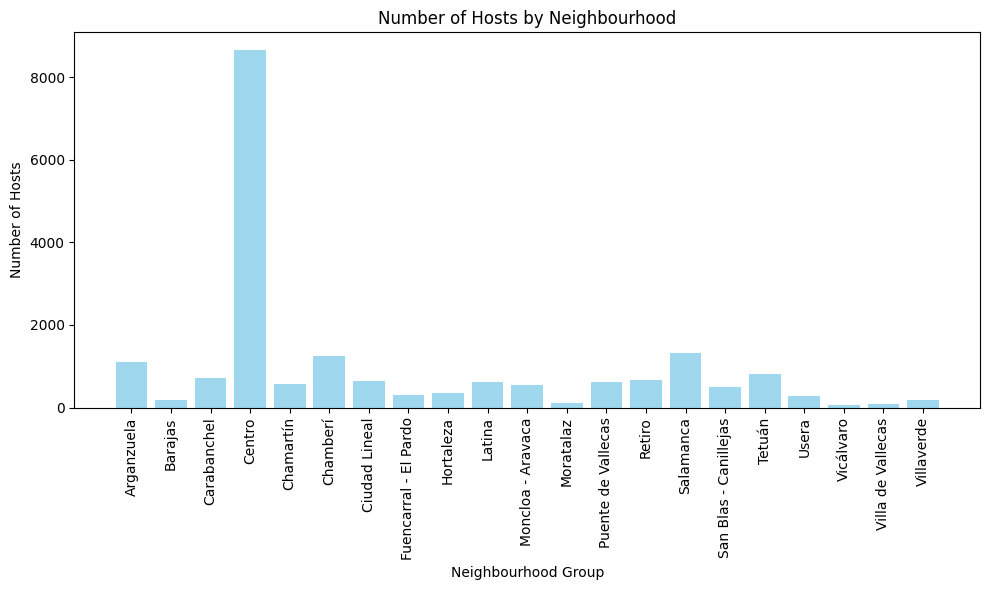

In [26]:
plt.figure(figsize=(10, 6))
plt.bar(groupped_data.index, groupped_data.values, color='skyblue', alpha=0.8)
plt.xlabel('Neighbourhood Group')
plt.ylabel('Number of Hosts')
plt.title('Number of Hosts by Neighbourhood')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Showing locations of places on the scatterplot, we got like a map of neighbourhoods here.

Text(0.5, 1.0, 'Airbnb by Neighbourhood')

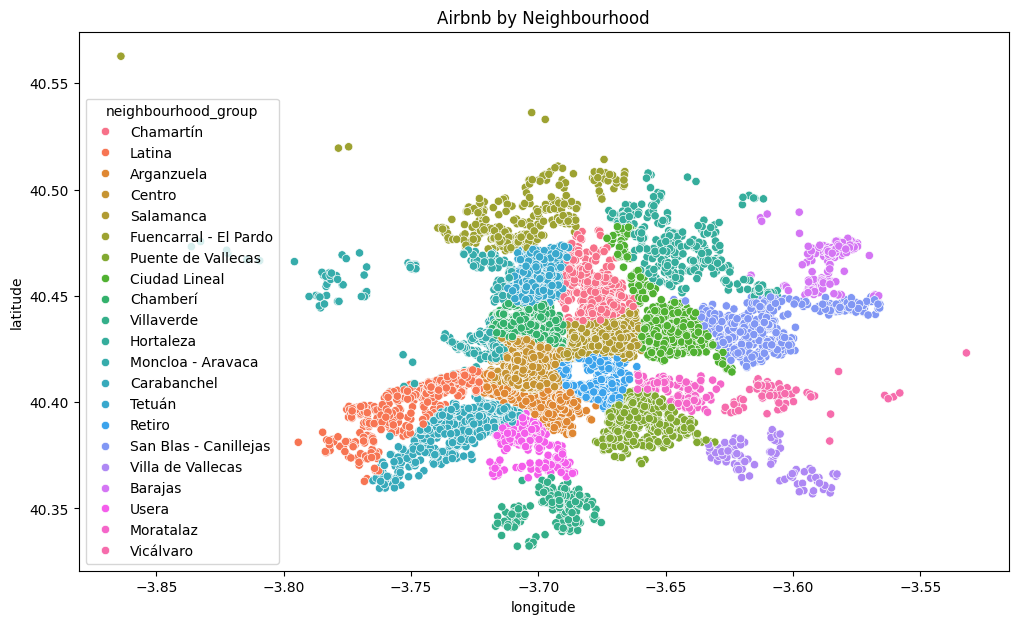

In [27]:
plt.figure(figsize = (12,7))
sns.scatterplot(listings_new,
    x = 'longitude',
    y = 'latitude',
    hue = 'neighbourhood_group')
plt.title('Airbnb by Neighbourhood')

Calculating the average price of the room depending on the neighbourhood and room_type.

In [28]:
mean_price_by_room = listings_new.groupby(['room_type','neighbourhood_group'])['price'].mean().reset_index()
mean_price_by_room

,room_type,neighbourhood_group,price
0,Entire home/apt,Arganzuela,221.954545
1,Entire home/apt,Barajas,122.365385
2,Entire home/apt,Carabanchel,145.796226
3,Entire home/apt,Centro,149.163934
4,Entire home/apt,Chamartín,125.557185
...,...,...,...
70,Shared room,Tetuán,47.500000
71,Shared room,Usera,71.750000
72,Shared room,Vicálvaro,200.000000
73,Shared room,Villa de Vallecas,100.000000


Visualisation of the relationship

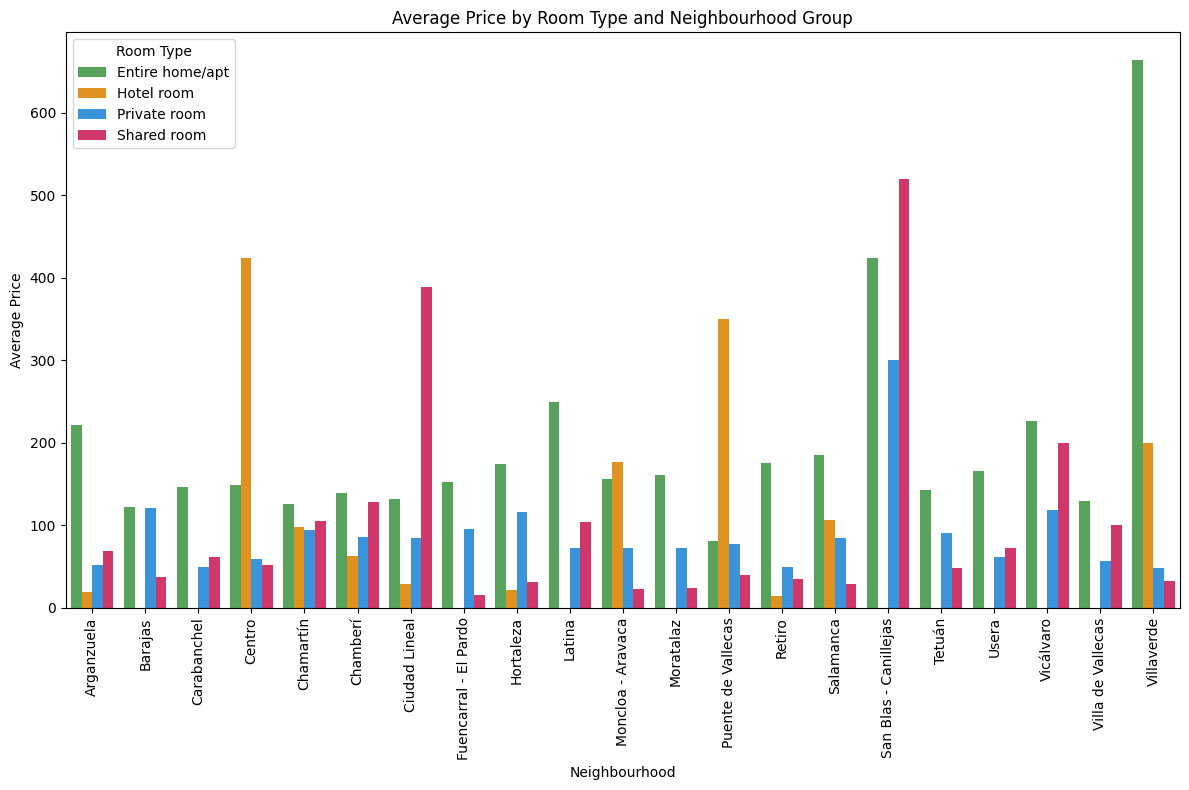

In [29]:
plt.figure(figsize=(12, 8))

custom_palette = ['#4CAF50', '#FF9800', '#2196F3', '#E91E63']

sns.barplot(
    data=mean_price_by_room,
    x='neighbourhood_group',
    y='price',
    hue='room_type',
    palette=custom_palette
)

plt.xlabel('Neighbourhood')
plt.ylabel('Average Price')
plt.title('Average Price by Room Type and Neighbourhood Group')
plt.legend(title='Room Type')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


###End of MK###

Get number of listings by neighbourhood

In [30]:
# Calculate the number of listings per neighborhood
listings_per_neighborhood = listings_new.groupby('neighbourhood_group').size()
listings_per_neighborhood

,0
neighbourhood_group,
Arganzuela,1104
Barajas,172
Carabanchel,708
Centro,8649
Chamartín,580
Chamberí,1252
Ciudad Lineal,649
Fuencarral - El Pardo,315
Hortaleza,364


### Scratch place ###

Showing locations of the airbnbs by room type

Text(0.5, 1.0, 'Airbnb by Room Type')

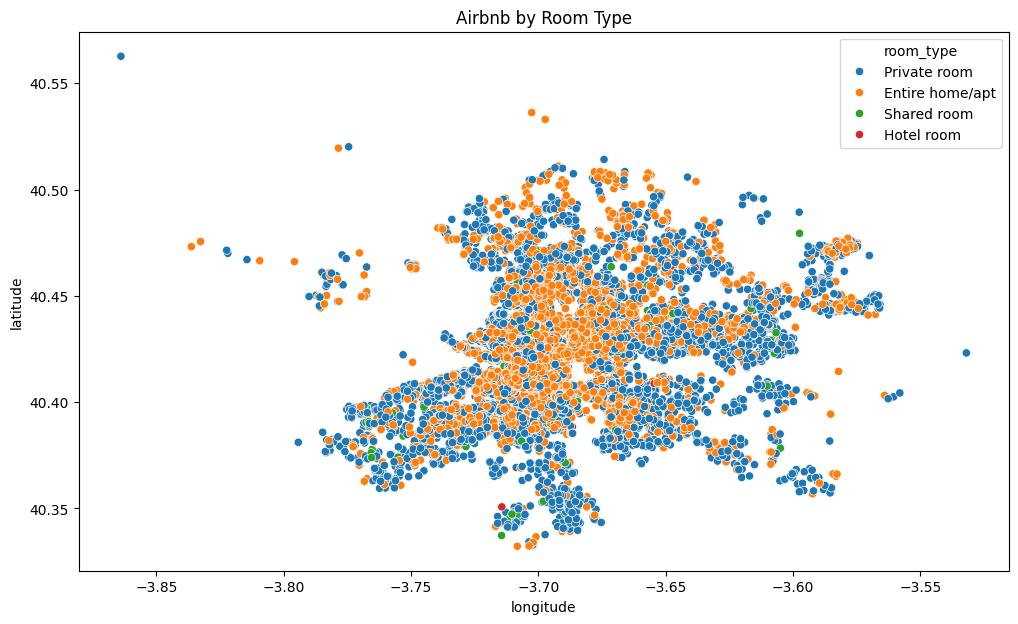

In [48]:
plt.figure(figsize = (12,7))
sns.scatterplot(listings_new,
    x = 'longitude',
    y = 'latitude',
    hue = 'room_type')
plt.title('Airbnb by Room Type')

Plot the availability against the price, to see whether there is some correlation between these two variables. I also colored the observations based on the neighbourhood

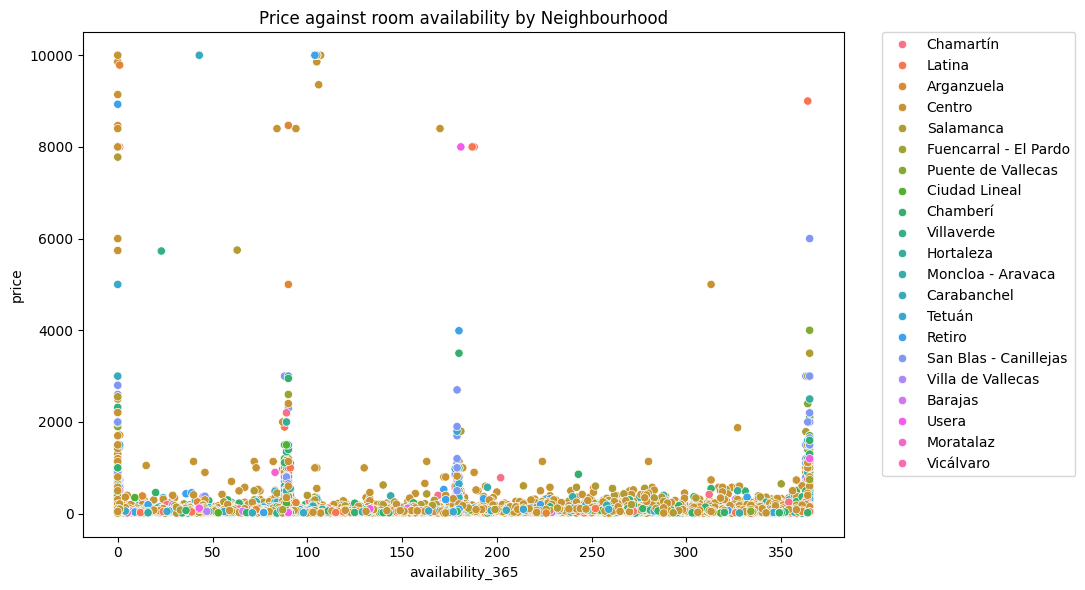

In [49]:
plt.figure(figsize = (11,6))
sns.scatterplot(listings_new,
    x = 'availability_365',
    y = 'price', # plotting availability again PRICE
    hue = 'neighbourhood_group'
               )
plt.title('Price against room availability by Neighbourhood')

# reposition legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()

Plot number of reviews against price

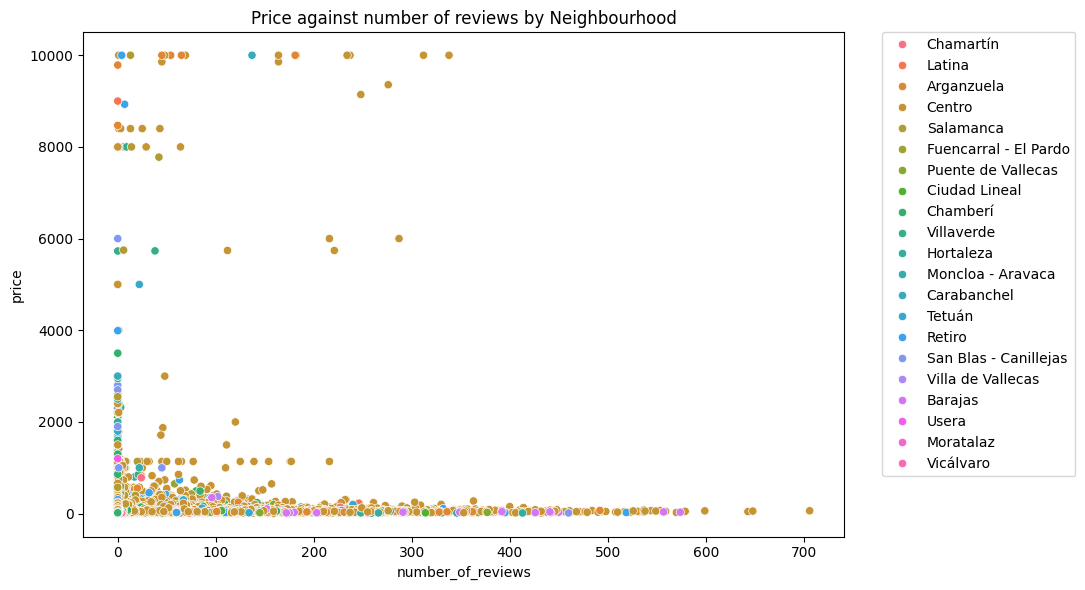

In [50]:
plt.figure(figsize = (11,6))
sns.scatterplot(listings_new,
    x = 'number_of_reviews',
    y = 'price',
    hue = 'neighbourhood_group'
               )
plt.title('Price against number of reviews by Neighbourhood')

# reposition legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()

Here I am plotting the number of beds of the individual airbnbs against the price to find out whether there is some correlation between these two variables

Text(0.5, 1.0, 'Price against number of beds')

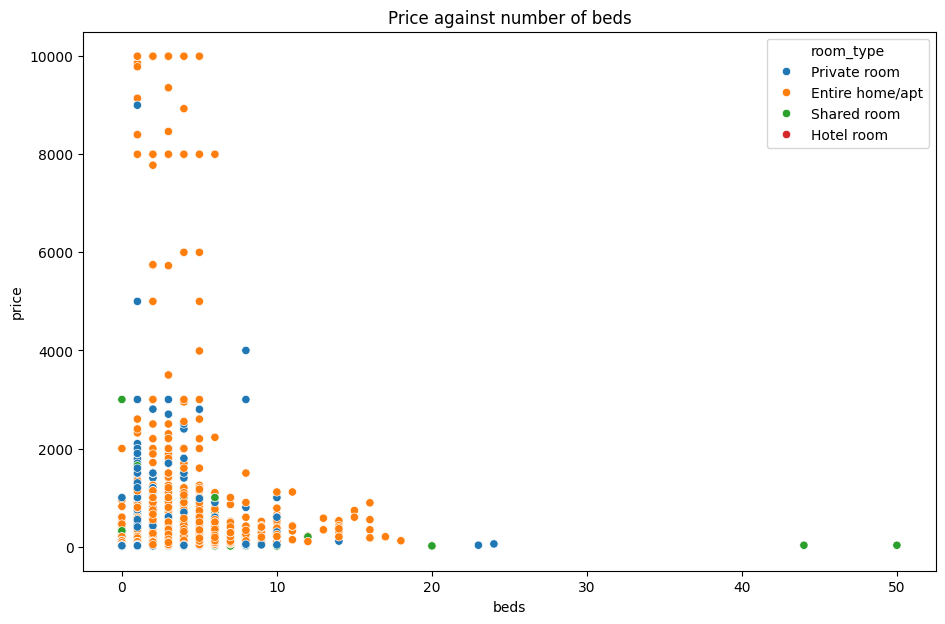

In [51]:
plt.figure(figsize = (11,7))
sns.scatterplot(listings_detailed,
    x = 'beds',
    y = 'price',
    hue = 'room_type')
plt.title('Price against number of beds')

With the previous plot we are able to detect some outliers, but to get the general trend is a bit difficult since there is a high density of points which makes the plot unreadable. To visualize better we grouped by the number of beds, calculate the mean of the prices of each group and then plot these two variables against each other.

Text(0, 0.5, 'Mean Price')

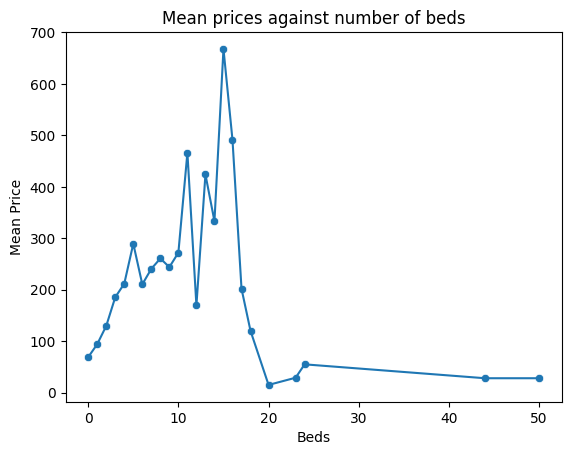

In [52]:
mean_price_by_beds = listings_detailed.groupby(['beds'])['price'].mean().reset_index()
sns.scatterplot(mean_price_by_beds,
    x = 'beds',
    y = 'price')
sns.lineplot(data=mean_price_by_beds,
             x='beds',
             y='price')
plt.title('Mean prices against number of beds')
plt.xlabel('Beds')
plt.ylabel('Mean Price')

## Predictive Models ##

In [ ]:
# inspecting data
print(listings_new.dtypes)
numerical_columns = listings_new.select_dtypes(include=['int64', 'float64']).columns
print(f'numerical data: {numerical_columns}')
categorical_cols = listings_new.select_dtypes(include=['object']).columns
print(f'categorical data: {categorical_cols}')

print(listings_new.isnull().sum()) # no missing data

id                                  int64
host_id                             int64
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                             float64
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object
numerical data: Index(['id', 'host_id', 'latitude', 'longitude', 'price', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')
categorical data: Index(['neighbourhood_group', 'neighbourhood', 'room_type'], dtype='object')
id                                   0
host_id                              0
neighbourhood_group                  0
nei

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,host_is_superhost,host_acceptance_rate,room_type_Hotel room,room_type_Private room,room_type_Shared room
1,40.40381,-3.74130,31.0,4,33,0.42,2,364,0,0.0,False,True,False
3,40.42183,-3.70529,92.0,5,10,0.13,1,72,0,0.0,False,False,False
5,40.38860,-3.69492,85.0,1,3,0.03,7,365,0,0.0,False,False,False
7,40.41259,-3.70105,54.0,3,8,0.11,1,0,0,0.0,False,False,False
8,40.41844,-3.71073,1400.0,3,0,0.00,3,365,1,97.0,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19605,40.42185,-3.70836,29.0,2,0,0.00,1,306,0,0.0,False,True,False
19606,40.37898,-3.75496,18.0,2,0,0.00,2,71,0,83.0,False,True,False
19608,40.42108,-3.70179,38.0,1,0,0.00,4,365,0,99.0,False,True,False
19610,40.41265,-3.72888,14.0,5,0,0.00,2,364,0,67.0,False,True,False


<Axes: >

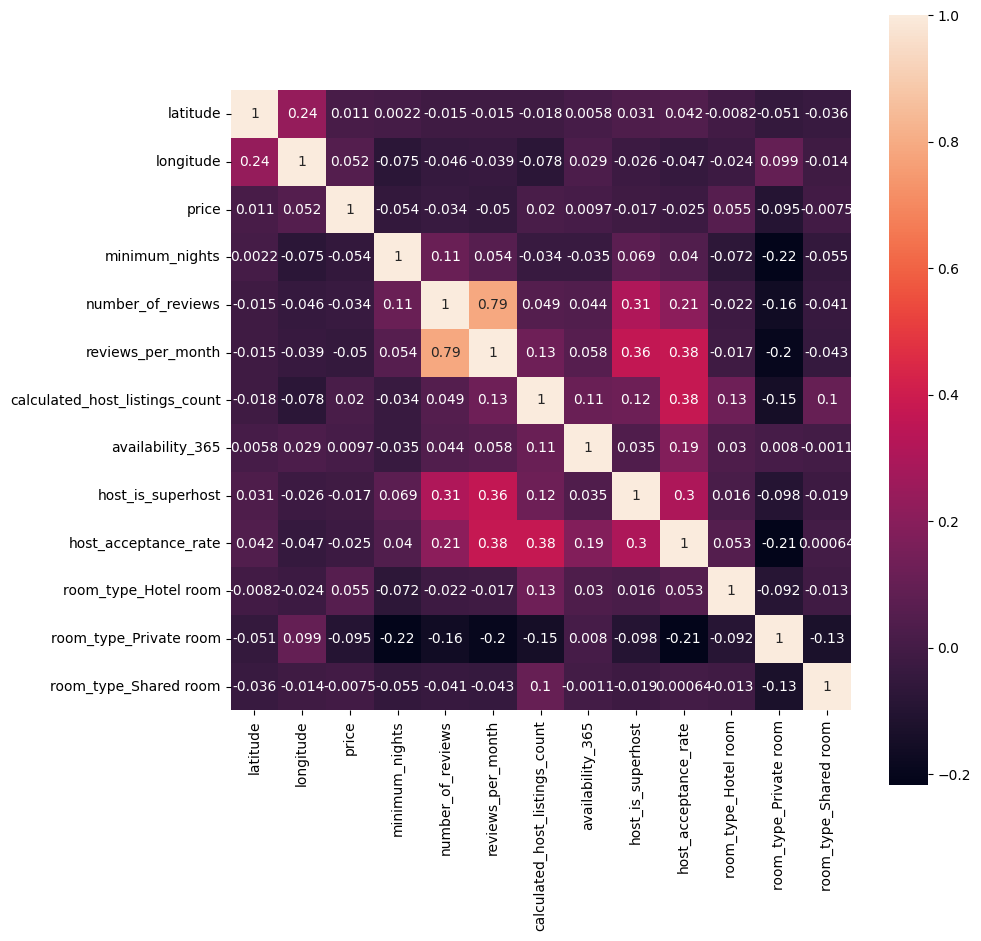

In [ ]:

# analysis shows a lot of outliers (TODO: boxplot), remove them
# TODO data distribution, show that the data

# 'id', 'host_id', 'latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count', 'availability_365', 'neighbourhood_group', 'neighbourhood', 'room_type'

# --- feature engineering ---
# delete columns we dont need and add the ones needed
# drop also neighbourhood and neighbourhood group because we already have the location with given latitude and longtitude
# use host_is_superhost and host_acceptance_rate as features too as they can be valuable for the price classification too
merged_data = pd.merge(listings_new, listings_detailed[['id', 'host_is_superhost', 'host_acceptance_rate']], on='id', how='left')
data = merged_data.drop(columns=['host_id', 'neighbourhood_group', 'neighbourhood', 'id']) # drop unnecessary columns for price prediction

# --- handling missing data ---
#print(merged_data.isnull().sum())
data.fillna({'host_is_superhost':'f'}, inplace=True)
data['host_is_superhost'] = data['host_is_superhost'].map({'t': 1, 'f': 0})

data['host_acceptance_rate'] = data['host_acceptance_rate'].str.replace('%', '').astype(float)
data.fillna({'host_acceptance_rate':0}, inplace=True)

data["reviews_per_month"] = data["reviews_per_month"].fillna(0)
#print(merged_data.isnull().sum())

# --- handling outliers ---
# method: IQR
# cols are the ones that need to be cleansed from its outliers, obviously latitude and longtitude dont have outliers as they indicate the location
# also host_acceptance_rate and host_is_superhost dont need any cleansing from outliers
cols = ["price","minimum_nights", "number_of_reviews", "calculated_host_listings_count", "availability_365", "reviews_per_month"]
Q1 = data[cols].quantile(0.25)
Q3 = data[cols].quantile(0.75)
IQR = Q3 - Q1
condition = ~((data[cols] < (Q1 - 1.5 * IQR)) | (data[cols] > (Q3 + 1.5 * IQR))).any(axis=1)
data_cleaned = data[condition]

# --- dealing with discrete data ----
# method: one hot encoding
preprocessed_data = pd.get_dummies(data_cleaned,drop_first=True)
#preprocessed_data.head()

# --- preparing feature and target values
X = preprocessed_data.drop(columns=['price'])  # Features
y = preprocessed_data['price']                 # Target

# --- data splitting ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# --- normalization ---
scaler = PowerTransformer()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

display(preprocessed_data)
plt.figure(figsize=(10,10))
sns.heatmap(preprocessed_data.corr(), square=True, annot=True)

In [ ]:
warnings.filterwarnings("ignore")

# Define a function to train and evaluate each model
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test, param_grid=None, use_grid_search=False):
    """
    Train and evaluate a regression model using given data.
    Optionally perform hyperparameter tuning using GridSearchCV.

    Parameters:
    - model: the model to train.
    - X_train, X_test: features for training and testing.
    - y_train, y_test: target for training and testing.
    - param_grid: hyperparameter grid (optional, used for GridSearchCV).
    - use_grid_search: whether to use GridSearchCV for hyperparameter tuning (default is False).

    Returns:
    - Dictionary of model performance metrics.
    """

    # Grid search if specified
    if use_grid_search and param_grid:
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        print(f"Best Hyperparameters: {best_params}")
    else:
        best_model = model
        best_model.fit(X_train, y_train)

    # Make predictions
    y_pred = best_model.predict(X_test)

    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Return results
    return {
        'model': best_model,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'y_pred': y_pred
    }

# Prepare dataset (assuming X_train, X_test, y_train, y_test are already defined)

param_grid_rf = {
    'n_estimators': [50, 100, 200, 500],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],       # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],       # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],         # Minimum samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider when looking for the best split
    'bootstrap': [True, False]             # Whether to use bootstrap samples for building trees
}

# Define models and hyperparameters
regression_models = {
    'Linear Regression': (LinearRegression(), None, False),
    'Decision Tree': (DecisionTreeRegressor(random_state=42), {
        'max_depth': [5, 7, 15, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 5],
        'criterion': ['squared_error', 'absolute_error'],
        'splitter': ['best', 'random']
    }, True),

    'Random Forest': (RandomForestRegressor(random_state=42), {
        'n_estimators': [100, 200, 500],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [2, 4],
        'max_features': [None, 'sqrt', 'log2'],
        'bootstrap': [True, False]
    }, True),

    'Gradient Boosting': (GradientBoostingRegressor(random_state=42), {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'subsample': [0.8, 0.9, 1.0],
        'max_features': ['auto', 'sqrt']
    }, True),

    'MLP Regressor': (MLPRegressor(random_state=42), {
        'hidden_layer_sizes': [(20, 20), (20, 10), (20, 15), (15,10)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [1000, 1500]
    }, True)
}

# Train and evaluate each model, and store results
regression_results = {}
for model_name, (model, param_grid, use_grid_search) in regression_models.items():
    print(f"Training {model_name}...")
    regression_results[model_name] = train_and_evaluate_model(model, X_train, X_test, y_train, y_test, param_grid, use_grid_search)

Training Linear Regression...
Training Decision Tree...
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best Hyperparameters: {'criterion': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2, 'splitter': 'random'}
Training Random Forest...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


KeyboardInterrupt: 

In [ ]:
# Display the results for all models
for model_name, result in regression_results.items():
    print(f"{model_name} Performance:")
    print(f"  MAE: {result['mae']:.4f}")
    print(f"  RMSE: {result['rmse']:.4f}")
    print(f"  R-squared: {result['r2']:.4f}")
    print("-" * 40)

In [ ]:
# From scatter plots of Actual vs Predicted You can tell how well the model is performing.
# For Ideal model, the points should be closer to a diagonal line.

def actual_vs_predicted_plot(y_test, y_pred, model_name):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2)
    plt.title(f'Actual vs Predicted for {model_name}')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.show()

for model_name, result in regression_results.items():
    actual_vs_predicted_plot(y_test, result['y_pred'], model_name)
    print(f"Completed plots for {model_name}")

## Price Tier Classification ##

In [ ]:
price_summary = preprocessed_data['price'].describe()
price_distribution = preprocessed_data['price'].hist(bins=50)  # Quick visualization of price distribution
price_summary
boxplot


Defining Price Tiers: \
    Low:    Prices <= 30 (25th percentile) \
    Medium: Prices between 30 and 80 (25th to 75th percentile) \
    High:   Prices > 80 (above the 75th percentile).

In [ ]:
def price_tier(price):
    if price <= 30:
        return 'Low'
    elif 30 < price <= 80:
        return 'Medium'
    else:
        return 'High'


# create a new column for price tiers
preprocessed_data['price_tier'] = preprocessed_data['price'].apply(price_tier)

X_classification = preprocessed_data.drop(columns=['price', 'price_tier'])  # Features
y_classification = preprocessed_data['price_tier']                                         # Target

# --- data splitting ---
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_classification, y_classification, test_size=0.25, random_state=42)

# --- normalization ---
scaler2 = PowerTransformer()
X_train_cls = scaler2.fit_transform(X_train_cls)
X_test_cls = scaler2.transform(X_test_cls)

In [ ]:
# Define parameter grids for each model
param_grids = {
    "Naive Bayes": {
        'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
    },
    "Decision Tree": {
        'max_depth': [5, 10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    "Neural Network": {
        'hidden_layer_sizes': [(50,), (100,), (100, 100), (150,)],
        'activation': ['tanh', 'relu'],
        'solver': ['adam', 'sgd'],
        'learning_rate': ['constant', 'adaptive']
    },
    "SVM": {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    },
    "KNN": {
        'n_neighbors': [3, 5, 7, 10],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }
}

# Initialize models
classification_models = {
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Neural Network": MLPClassifier(max_iter=1000, random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier()
}

roc_data = []
for model_name, model in classification_models.items():
    print(f"Training {model_name} with GridSearchCV...")

    # set up GridSearchCV with 5-fold cross-validation
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

    # fit the model using GridSearchCV
    grid_search.fit(X_train_cls, y_train_cls)

    # get the best model from grid search
    best_model = grid_search.best_estimator_

    # predict probabilities on the test set (for ROC curve)
    y_prob = best_model.predict_proba(X_test_cls)  # Probability scores for each class

    # compute ROC curve for each class (considering 'High' as the positive class)
    fpr, tpr, _ = roc_curve(y_test_cls, y_prob[:, 2], pos_label="High")  # Index 2 corresponds to "High" class
    roc_auc = auc(fpr, tpr)

    # store the data for plotting later
    roc_data.append((fpr, tpr, roc_auc, model_name))

    # print the classification report
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test_cls, grid_search.predict(X_test_cls)))

    # print confusion matrix
    conf_matrix = confusion_matrix(y_test_cls, grid_search.predict(X_test_cls))
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()


In [ ]:
# plot all ROC curves on one plot
plt.figure(figsize=(10, 8))

# plot the ROC curve for each model
for fpr, tpr, roc_auc, model_name in roc_data:
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

# plot the diagonal line (no discrimination)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# final ROC curve plot settings
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for All Models')
plt.legend(loc='lower right')
plt.show()